In [161]:
#import libraries
import pandas as pd
import numpy as np
import csv
import ast
import re
from prettytable import PrettyTable

from collections import Counter

import time
import random

#data visualization libraries
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

#NLP & ML libraries
from gensim.models import Word2Vec
from gensim.utils import tokenize
from gensim.models.phrases import Phrases
from textblob import TextBlob
from nltk import FreqDist

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from scipy.sparse import save_npz, load_npz

In [162]:
#set seed so that code output is deterministic
random.seed(30)  # Set the seed for Python's random module
np.random.seed(30)  # Set the seed for NumPy's random module

In [163]:
#import cleaned data

def list_converter(text):
    #to revert list->str conversion from pd.read_csv
    return ast.literal_eval(text)


data = pd.read_csv('Data/training_corpus.csv', converters ={'tokens':list_converter})

In [164]:
data = data.drop(columns = ['index'])
print (data.shape)
data.head()

(99186, 7)


,text_type,ID,year,long_text,clean_text,word_count,tokens
0,comment,gtfo2hl,2021,"*Cuntry roads, take me hoem*",cuntry roads hoem,3,"[cuntry, road, hoem]"
1,comment,gtfqkbv,2021,"That’s been there for several years, sent a pi...",years sent pic cuntry friend long time ago,8,"[year, send, pic, cuntry, friend, long, time, ..."
2,comment,gtfou07,2021,I am single and I have not traveled to any cun...,single traveled cuntry past year,5,"[single, travel, cuntry, past, year]"
3,comment,gtfrgpe,2021,What happens when you shop at dragon mart...,happens shop dragon mart,4,"[happen, shop, dragon, mart]"
4,comment,gthiiwi,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious springs souk,4,"[absolutely, hilarious, spring, souk]"


In [165]:
#include column with additional stopwords removal
#created the filtered corpus from another notebook and imported it here for use
# Read the file
with open('updated_corpus_new.txt', 'r') as f:
    updated_tokens = f.readlines()

# Remove newline characters
updated_tokens = [line.strip() for line in updated_tokens]


data['updated_tokens'] = updated_tokens

In [166]:

#convert list of strings to dataframe column with list of tokens on each row
data['updated_tokens'] = data['updated_tokens'].apply(lambda x: list(tokenize(x)))

In [167]:
#dataframe of all empty token lists due to removal of additional stopwords
empty_tokens = data[data['updated_tokens'].apply(lambda x: len(x) == 0)]

empty_tokens.shape

(3171, 8)

In [168]:
#adjust corpus to remvoe rows with empty token lists
row_id = empty_tokens['ID'] #id of rows with empty token list

updated_data = data[~data['ID'].isin(row_id)]
updated_data

,text_type,ID,year,long_text,clean_text,word_count,tokens,updated_tokens
0,comment,gtfo2hl,2021,"*Cuntry roads, take me hoem*",cuntry roads hoem,3,"[cuntry, road, hoem]",[road]
2,comment,gtfou07,2021,I am single and I have not traveled to any cun...,single traveled cuntry past year,5,"[single, travel, cuntry, past, year]","[single, travel, past]"
3,comment,gtfrgpe,2021,What happens when you shop at dragon mart...,happens shop dragon mart,4,"[happen, shop, dragon, mart]","[shop, dragon, mart]"
4,comment,gthiiwi,2021,"That’s just absolutely hilarious, is this in t...",absolutely hilarious springs souk,4,"[absolutely, hilarious, spring, souk]","[hilarious, spring, souk]"
6,comment,gtfw6yj,2021,Eugene's first day as a signwriter for Country...,eugene s day signwriter country artificial pro...,8,"[eugene, s, day, signwriter, country, artifici...","[artificial, product]"
...,...,...,...,...,...,...,...,...
99181,submission,14f46ji,2023,"Best beauty saloons in Dubai? Hello fellas, I ...",best beauty saloons dubai hello fellas moved w...,35,"[good, beauty, saloon, dubai, hello, fellas, m...","[beauty, saloon, hello, wife, real, saloon, re..."
99182,submission,14f4uyi,2023,Found the r/dubai redditors who kept telling m...,found r dubai redditors kept telling know navi...,10,"[find, r, dubai, redditor, keep, tell, know, n...","[navigate, roundabout]"
99183,submission,14f4ri3,2023,Scam ? Healthy.line My sister has a CBD debit ...,scam healthy line sister cbd debit card month ...,47,"[scam, healthy, line, sister, cbd, debit, card...","[scam, healthy, line, sister, cbd, debit, card..."
99184,submission,14f4k3r,2023,Thoughts on Expo City properties? Anyone else ...,thoughts expo city properties checked expo cit...,21,"[thought, expo, city, property, check, expo, c...","[expo, property, expo, sale, page, pleasant, d..."


## **Word2Vec Model** 

### FULL CORPUS -->After initial preprocessing

In [169]:
#convert df['tokens'] to list of strings for word2vec model
corpus = data['tokens'].tolist()#.apply(lambda token: ' '.join(token)).tolist()

corpus[:5]

[['cuntry', 'road', 'hoem'],
 ['year', 'send', 'pic', 'cuntry', 'friend', 'long', 'time', 'ago'],
 ['single', 'travel', 'cuntry', 'past', 'year'],
 ['happen', 'shop', 'dragon', 'mart'],
 ['absolutely', 'hilarious', 'spring', 'souk']]

In [170]:
#code from codebasics and semicolon, both on youtube

#instantiate word2vec model
full_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 300)
   
#build a vocabulary
full_corpus_model.build_vocab(corpus, progress_per = 1000)

In [171]:
full_corpus_model.corpus_count #number of sentences/documents

99186

In [172]:
#train the word2vec model

full_corpus_model.train(
                corpus,
                total_examples = full_corpus_model.corpus_count,
                epochs = full_corpus_model.epochs
)

full_corpus_model.save('pretrained_models/full_corpus_model.model') #save model locally

In [173]:
num_unique_words = len(full_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")


Number of unique words in the vocabulary: 21945


In [174]:
full_corpus_model.wv.most_similar ('lulu')

[('nesto', 0.959927499294281),
 ('cafeteria', 0.958613395690918),
 ('hypermarket', 0.9511842131614685),
 ('waitrose', 0.9500824809074402),
 ('souq', 0.9491420984268188),
 ('vegetable', 0.9481875896453857),
 ('carton', 0.942730724811554),
 ('veggie', 0.9416506886482239),
 ('thrift', 0.9401313066482544),
 ('spinneys', 0.9396886229515076)]

In [175]:
full_corpus_model.wv.most_similar('reddit')

[('subreddit', 0.8991238474845886),
 ('sub', 0.8968182802200317),
 ('mod', 0.878785252571106),
 ('thread', 0.8401961922645569),
 ('post', 0.8380653858184814),
 ('delete', 0.8236581087112427),
 ('moderator', 0.8221286535263062),
 ('discussion', 0.8206560015678406),
 ('forum', 0.8063229918479919),
 ('clutter', 0.8037144541740417)]

In [176]:
full_corpus_model.wv.doesnt_match(['ejari', 'rera', 'dewa', 'drive'])

'drive'

## **Word2Vec Model** with custom stopwords removed from corpus

In [177]:
#convert ['tokens'] column to list of strings for word2vec model
filtered_corpus = updated_data['updated_tokens'].tolist()

filtered_corpus[:5]

[['road'],
 ['single', 'travel', 'past'],
 ['shop', 'dragon', 'mart'],
 ['hilarious', 'spring', 'souk'],
 ['artificial', 'product']]

In [227]:
#code from codebasics and semicolon, both on youtube

#instantiate word2vec model on filtered corpus
filtered_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 300)
   
#build a vocabulary
filtered_corpus_model.build_vocab(filtered_corpus, progress_per = 1000)



In [228]:
#number of sentences in vocabulary
filtered_corpus_model.corpus_count

96015

In [229]:
#train the word2vec model

filtered_corpus_model.train(
                filtered_corpus,
                total_examples = filtered_corpus_model.corpus_count,
                epochs = filtered_corpus_model.epochs
)

filtered_corpus_model.save('pretrained_models/filtered_corpus_model.model') #save model locally

In [230]:
num_unique_words = len(filtered_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")

Number of unique words in the vocabulary: 7878


In [231]:
filtered_corpus_model.wv.most_similar ('lulu')

[('carrefour', 0.9825636148452759),
 ('supermarket', 0.965387761592865),
 ('fruit', 0.9633022546768188),
 ('vegetable', 0.9590082168579102),
 ('darahim', 0.9541527628898621),
 ('cafeteria', 0.9481195211410522),
 ('spinney', 0.9477810859680176),
 ('kg', 0.947008490562439),
 ('coupon', 0.9450790286064148),
 ('waitrose', 0.9446305632591248)]

In [232]:
filtered_corpus_model.wv.most_similar ('fish')

[('spice', 0.9752476215362549),
 ('farm', 0.9663492441177368),
 ('pickle', 0.9561372399330139),
 ('salad', 0.9530550241470337),
 ('delicious', 0.9525803923606873),
 ('cooking', 0.9497455358505249),
 ('vegetable', 0.9497189521789551),
 ('garlic', 0.9483018517494202),
 ('laban', 0.9466755390167236),
 ('chocolate', 0.9461941123008728)]

In [233]:
filtered_corpus_model.wv.most_similar ('bridge')

[('gate', 0.9737350344657898),
 ('szr', 0.9706458449363708),
 ('jam', 0.9613057971000671),
 ('khail', 0.9588261842727661),
 ('pavement', 0.9561305046081543),
 ('rush', 0.9513409733772278),
 ('busy', 0.950473427772522),
 ('stick', 0.9476977586746216),
 ('cycling', 0.9465822577476501),
 ('footpath', 0.945829451084137)]

In [234]:
filtered_corpus_model.wv.most_similar('reddit')

KeyError: "Key 'reddit' not present in vocabulary"

## **Word2Vec with bigrams**

In [186]:
#first model on full corpus

#code from gensim documentation

#train bigram detector
bigram_transform = Phrases (corpus, min_count = 1) #default threshold is 10.0, fewer phrases will be created

In [187]:
#check performance of bigram transform model
new_sentence = corpus[330]
print(bigram_transform[new_sentence])

['anymore', 'new', 'labor_law', 'common', 'blatant', 'good', 'company', 'care', 'sale', 'promotional', 'bdm', 'post', 'hire', 'look', 'filter', 'photo_cv', 'rife', 'real_estate', 'industry', 'say', 'uae', 'young', 'country', 'learn', 'motivation', 'law', 'change', 'align', 'progressive', 'practice', 'ahead', 'way', 'nature', 'place', 'live']


In [188]:
#create corpus with bigrams
bigram_full_corpus = [bigram_transform[sentence] for sentence in corpus]

#code from codebasics and semicolon, both on youtube

#instantiate word2vec model
bigram_full_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 300)
   
#build a vocabulary
bigram_full_corpus_model.build_vocab(bigram_full_corpus, progress_per = 1000)

In [189]:
bigram_full_corpus_model.corpus_count

99186

In [190]:
#train the word2vec model

bigram_full_corpus_model.train(
                bigram_full_corpus,
                total_examples = bigram_full_corpus_model.corpus_count,
                epochs = bigram_full_corpus_model.epochs
)

bigram_full_corpus_model.save('pretrained_models/bigram_full_corpus_model.model') #save model locally

In [191]:
num_unique_words = len(bigram_full_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")

Number of unique words in the vocabulary: 52736


In [192]:
bigram_full_corpus_model.wv.most_similar('lulu')

[('cheese', 0.9945626854896545),
 ('wrap', 0.9934541583061218),
 ('bread', 0.9925803542137146),
 ('powder', 0.9925659894943237),
 ('vegetable', 0.9923999309539795),
 ('juice', 0.9921454787254333),
 ('mcdonald', 0.9920008182525635),
 ('areej', 0.9912693500518799),
 ('avocado', 0.9911080002784729),
 ('pickl', 0.9909618496894836)]

In [193]:
bigram_full_corpus_model.wv.most_similar('real_estate')

[('investment', 0.9509590268135071),
 ('market', 0.9489184617996216),
 ('oversupply', 0.9414268732070923),
 ('market_rate', 0.940448522567749),
 ('invest', 0.939044177532196),
 ('yearly_rent', 0.9362387657165527),
 ('property', 0.93576979637146),
 ('depend', 0.9341921806335449),
 ('currently', 0.9293032884597778),
 ('mnc', 0.9285474419593811)]

In [194]:
bigram_full_corpus_model.wv.most_similar('reddit')

[('r_dubai', 0.9751532673835754),
 ('sub', 0.9610635638237),
 ('mod', 0.9577868580818176),
 ('thread', 0.953221321105957),
 ('subreddit', 0.952864944934845),
 ('read', 0.9500852823257446),
 ('mod_delete', 0.9480193853378296),
 ('thank_informative', 0.9399415850639343),
 ('mod_remove', 0.936608076095581),
 ('post_remove', 0.9306941032409668)]

In [195]:
#second model on filtered corpus 
#create corpus with bigrams
bigram_filtered_corpus = [bigram_transform[sentence] for sentence in filtered_corpus]

#code from codebasics and semicolon, both on youtube

#instantiate word2vec model
bigram_filtered_corpus_model = Word2Vec (window = 5, min_count = 2, workers = 4, vector_size = 300)
   
#build a vocabulary
bigram_filtered_corpus_model.build_vocab(bigram_filtered_corpus, progress_per = 1000)


In [196]:
bigram_filtered_corpus_model.corpus_count

96015

In [197]:
#train the word2vec model

bigram_filtered_corpus_model.train(
                bigram_filtered_corpus,
                total_examples = bigram_filtered_corpus_model.corpus_count,
                epochs = bigram_filtered_corpus_model.epochs
)

bigram_filtered_corpus_model.save('pretrained_models/bigram_filtered_corpus_model.model') #save model locally

In [198]:
num_unique_words = len(bigram_filtered_corpus_model.wv.index_to_key)
print(f"Number of unique words in the vocabulary: {num_unique_words}")

Number of unique words in the vocabulary: 30615


In [199]:
bigram_filtered_corpus_model.wv.most_similar('real_estate')

[('market', 0.9893451929092407),
 ('property', 0.987251877784729),
 ('sale', 0.9857436418533325),
 ('value', 0.9850625395774841),
 ('agent', 0.9846907258033752),
 ('capital_gain', 0.9830077290534973),
 ('invest', 0.9813506007194519),
 ('contribute_skyrocket', 0.9765533208847046),
 ('investment', 0.9689631462097168),
 ('negotiate_landlord', 0.9674742221832275)]

In [200]:
bigram_filtered_corpus_model.wv.most_similar('reddit')

KeyError: "Key 'reddit' not present in vocabulary"

### **WORD CLUSTERING WITH WORD2VEC MODEL**

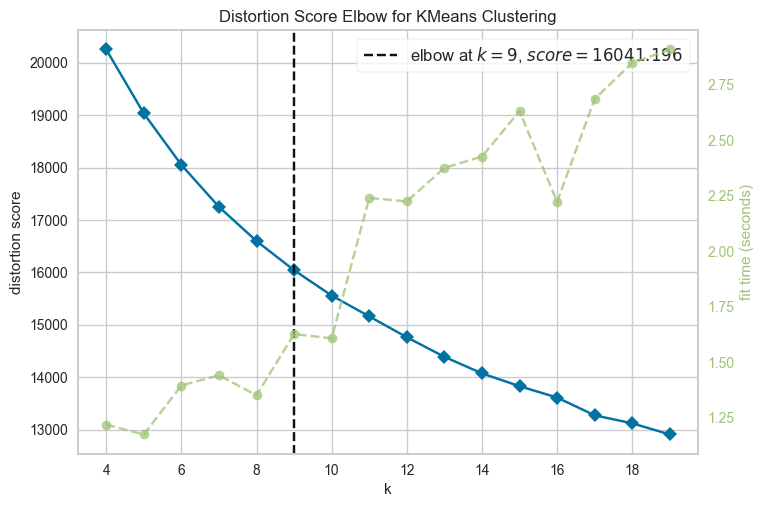

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [235]:
word_vectors = filtered_corpus_model.wv.vectors #2d word vectors for clustering

#determine optimum k-clusters using yellowbrick visualizer


kmeans = KMeans(init = 'k-means++', n_init = 10, max_iter = 200, random_state = 0)
visualizer = KElbowVisualizer(kmeans, k = (4,20))

visualizer.fit(word_vectors)
visualizer.show()



In [238]:
num_clusters = 14

# Kmeans clustering
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=200, n_init=10, random_state=0)
kmeans.fit(word_vectors)

# cluster label for each word
word_clusters = kmeans.labels_

# map word to cluster label
word_to_cluster = {word: cluster for word, cluster in zip(filtered_corpus_model.wv.index_to_key, word_clusters)}

# print 10 words in each cluster
for i in range(num_clusters):
    words_in_cluster = [word for word, cluster in word_to_cluster.items() if cluster == i]
    print(f"Cluster {i}: {words_in_cluster[:10]}")

Cluster 0: ['break', 'line', 'stand', 'imagine', 'avoid', 'hit', 'early', 'fun', 'stick', 'step']
Cluster 1: ['take', 'case', 'police', 'law', 'report', 'safe', 'test', 'rule', 'covid', 'public']
Cluster 2: ['real', 'deal', 'meet', 'course', 'support', 'system', 'set', 'decide', 'difference', 'advice']
Cluster 3: ['single', 'play', 'rest', 'type', 'chance', 'past', 'simple', 'recently', 'party', 'suggest']
Cluster 4: ['family', 'read', 'learn', 'parent', 'social', 'child', 'human', 'community', 'movie', 'complain']
Cluster 5: ['food', 'water', 'order', 'restaurant', 'delivery', 'tip', 'eat', 'shop', 'store', 'drink']
Cluster 6: ['experience', 'business', 'visa', 'salary', 'low', 'government', 'school', 'base', 'india', 'passport']
Cluster 7: ['call', 'service', 'card', 'bank', 'charge', 'provide', 'customer', 'emirate', 'website', 'credit']
Cluster 8: ['area', 'mall', 'walk', 'visit', 'build', 'building', 'house', 'outside', 'night', 'sharjah']
Cluster 9: ['local', 'indian', 'culture',

## **CREATE DOCUMENT VECTORS FROM WORD EMBEDDINGS**

In [239]:
#create document vectors using average of word vectors

#code from Dylan Castillo https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/#train-word2vec-model

def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(updated_data['updated_tokens'].values, model=filtered_corpus_model)
len(vectorized_docs), len(vectorized_docs[0])

(96015, 300)

In [240]:
type(vectorized_docs[330])

numpy.ndarray

In [241]:
vectorized_docs[330].shape

(300,)

In [242]:
print(np.array(vectorized_docs).ndim)

2


In [206]:
#do some document similarity things

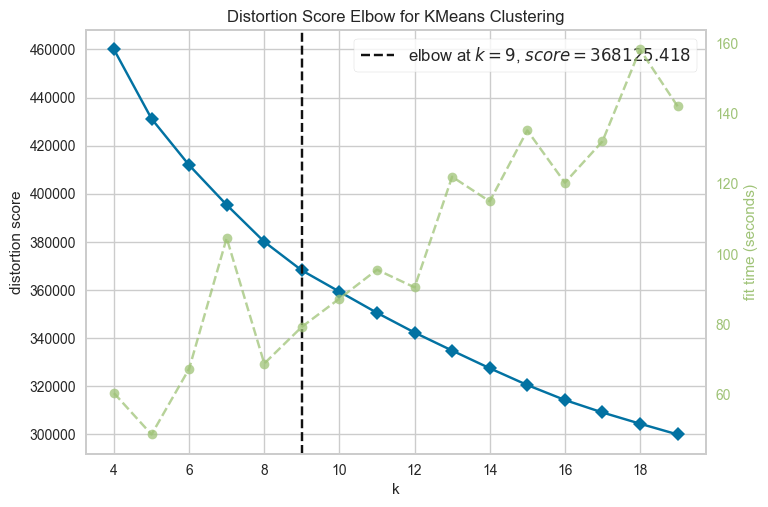

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [243]:
#determine optimum k-clusters using yellowbrick visualizer


kmeans = KMeans(init = 'k-means++', n_init = 30, max_iter =300, random_state = 0)
visualizer = KElbowVisualizer(kmeans, k = (4,20))

visualizer.fit(np.array(vectorized_docs))
visualizer.show()


In [222]:
%%timeit
#check silhouette scores

#determine optimum k-clusters

k_range = [4,5,8,10,12,14,18,20]
sil_score = {}

for k in k_range:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 10, random_state = 20)#, batch_size = 5000)
    kmeans.fit(np.array(vectorized_docs))
    #silhouette scores
    if k >1:
        score = silhouette_score(np.array(vectorized_docs), kmeans.labels_)
        sil_score.update({f'{k} clusters':score})
    
    
print (sil_score)

{'4 clusters': 0.110924184, '5 clusters': 0.11510913, '8 clusters': 0.11034354, '10 clusters': 0.12388892, '12 clusters': 0.08525599, '14 clusters': 0.08956181, '18 clusters': 0.09868131, '20 clusters': 0.07323412}


KeyboardInterrupt: 

In [244]:
true_k = 12

model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=10, random_state = 12)

model.fit(np.array(vectorized_docs))

# Assign each document to a cluster
clusters = model.labels_#predict(np.array(vectorized_docs))

# For each cluster
for i in range(true_k):
    print(f"Cluster {i}:")

    # Find all the documents that belong to this cluster
    docs_in_cluster = [doc for doc, cluster in zip(updated_data['updated_tokens'].values, clusters) if cluster == i]

    # Count the frequency of each word in these documents
    word_freq = Counter(word for doc in docs_in_cluster for word in doc)

    # Print the 10 words with the highest frequency
    for word, freq in word_freq.most_common(10):
        print(f"    {word}")


Cluster 0:
    arabic
    culture
    arab
    english
    indian
    language
    muslim
    racism
    racist
    expat
Cluster 1:
    take
    drive
    call
    stop
    experience
    buy
    area
    small
    walk
    real
Cluster 2:
    price
    buy
    sell
    cost
    rent
    cheap
    market
    property
    aed
    expensive
Cluster 3:
    lane
    drive
    road
    speed
    driver
    fast
    limit
    traffic
    slow
    flash
Cluster 4:
    visa
    passport
    apply
    golden
    travel
    law
    insurance
    visit
    employer
    resident
Cluster 5:
    salary
    business
    experience
    low
    offer
    family
    market
    government
    cost
    tax
Cluster 6:
    water
    food
    eat
    chicken
    taste
    burger
    drink
    shawarma
    hot
    restaurant
Cluster 7:
    delivery
    tip
    order
    food
    restaurant
    service
    driver
    talabat
    customer
    noon
Cluster 8:
    card
    bank
    credit
    etisalat
    call
 

### **DOCUMENT CLUSTERING WITH DBSCAN**

In [ ]:
### should i standardize the vectors?

In [260]:
#use a grid search to determine optimal hyperparameters

#code from Gregg Hogg on youtube DBSCAN Clustering Coding Tutorial in Python & Scikit-learn

#hyperparameters
epsilon = np.linspace(0.1, 1, num = 5)
min_samples = np.arange(2,20, step = 3)

import itertools

param_combinations = list(itertools.product(epsilon, min_samples))
len(param_combinations)

30

In [252]:
#clustering function

def cluster_scores_labels(combinations, doc_vectors):
    scores = [] #silhouette scores for each dbscan cluster model on each hyperparameter combination
    all_labels_list = [] #cluster labels for each dbscan cluster model on each hyperparameter combination
    
    for i, (eps, samples) in enumerate(param_combinations):
        dbscan_model = DBSCAN(eps = eps, min_samples = samples) #dbscan model for each hyperparam combinations
        dbscan_model.fit(doc_vectors) #fit each model to the data to create the clusters
        
        labels = dbscan_model.labels_ #labels for the clusters
        labels_set = set(labels) #collection of the unique cluster labels
        num_clusters = len(labels_set) # number of clusters incl. outlier clusters
        
        if -1 in labels_set:
            num_clusters -= 1 #remove outlier cluster from count of clusters
            
        
        if (num_clusters < 2) or (num_clusters > 20): # it highlight models that create less than 2 clusters so that we can disregard them
            scores.append(-10)
            all_labels_list. append ('bad')
            c = (eps, samples) #hyperparameters for the model in question
            print (f"Combination {c} on iteration {i+1} of {len(param_combinations)} has {num_clusters} clusters. Moving on")
            continue
        #continue iterating through hyperparameters
        scores.append(silhouette_score(doc_vectors, labels)) #store scores of usable models
        all_labels_list.append(labels) #score labels of usable models
        print (f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, Number of clusters: {num_clusters}")
        
    best_index = np.argmax(scores) #index of highest silhouette score
    best_parameters = combinations[best_index] #best hyperparameters using best_index
    best_labels = all_labels_list[best_index] #label of best performing model
    best_score = scores[best_index] #score of best performing model
    
    return {
        'best_epsilon': best_parameters[0],
        'best_min_samples': best_parameters[1],
        'best_labels': best_labels,
        'best_score': best_score
    }       

In [253]:
best_model = cluster_scores_labels(param_combinations,np.array(vectorized_docs))

In [261]:
# Initialize lists to store the results
best_score = -np.inf
best_epsilon = None
best_min_samples = None
best_labels = None

# Iterate over all combinations of hyperparameters
for eps in epsilon:
    for samples in min_samples:
        # Create and fit a DBSCAN model
        dbscan_model = DBSCAN(eps=eps, min_samples=samples)
        dbscan_model.fit(np.array(vectorized_docs))

        # Get the cluster labels
        labels = dbscan_model.labels_

        # Calculate the silhouette score, ignoring cases with less than 2 clusters
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if num_clusters >= 2 or num_clusters <=20:
            score = silhouette_score(np.array(vectorized_docs), labels)

            # If this score is the best so far, update the best hyperparameters and labels
            if score > best_score and score >= 0:
                best_score = score
                best_epsilon = eps
                best_min_samples = samples
                best_labels = labels
                
                # Print the details of the best model so far
                print(f"New best model: epsilon={best_epsilon}, min_samples={best_min_samples}, score={best_score}, and number of clusters: {num_clusters}")


# Print the best hyperparameters, labels, and score
print({
    'best_epsilon': best_epsilon,
    'best_min_samples': best_min_samples,
    'best_labels': best_labels,
    'best_score': best_score
})

KeyboardInterrupt: 